In [1]:
library(Seurat)
library(dplyr)
library(ComplexHeatmap)
library(circlize)
library(SeuratDisk)
library(Seurat)
library(dplyr)
library(ggplot2)
library(ComplexHeatmap)
library(circlize)


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effo

In [2]:

# ---------------------------------------------------------
# 0. Load your merged object
# ---------------------------------------------------------
obj <- readRDS("/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Psoriasis_data/GSE228421_integrated_annotated.rds")



In [3]:
unique(obj$paper_annotation)
unique(obj$site)
unique(obj$timepoint)


[1] "KC_Suprabasal"     "Fibroblast_Dermal" "KC_Basal"         
 [4] "Endothelial_Blood" "Endothelial_Lymph" "Melanocyte"       
 [7] "Monocyte"          "Mast"              "Macrophage"       
[10] "pDC"

[1] "lesional"     "non_lesional"

[1] "day0"  "day3"  "day14"

In [4]:
DefaultAssay(obj) <- "RNA"


As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.


Names of identity class contain underscores ('_'), replacing with dashes ('-')
This message is displayed once every 8 hours.


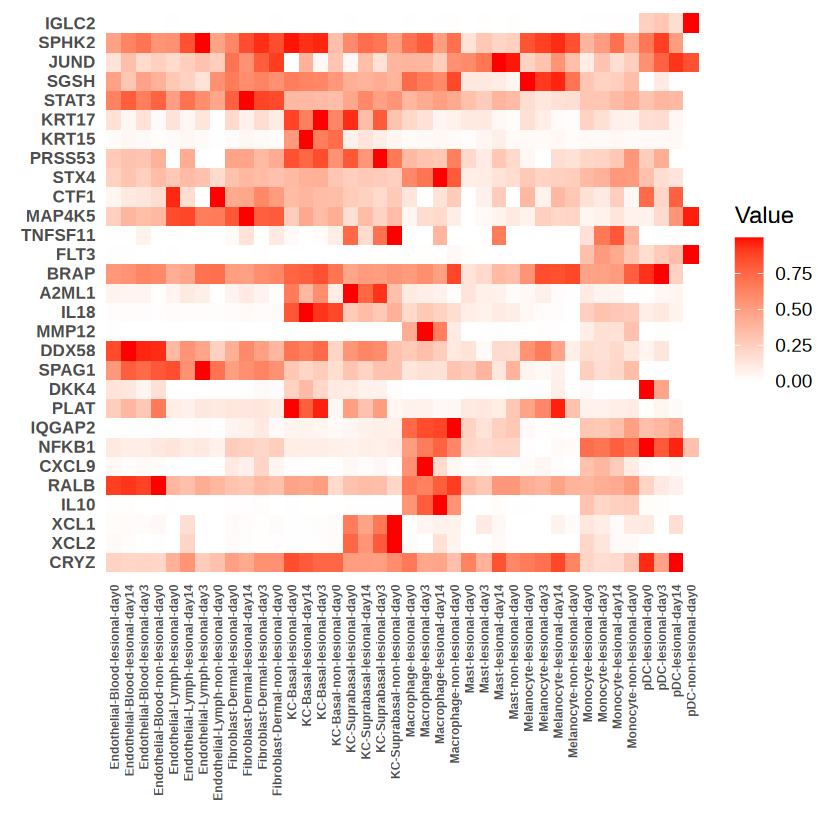

In [ ]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(reshape2)

# -------------------------------
# 1. Gene list
# -------------------------------
genes <- c(
  "BRAP","STX4","FLT3","NFKB1","DDX58","CXCL9","IGLC2","IQGAP2","IL18",
  "PRSS53","MMP12","SPAG1","SGSH","XCL1","MAP4K5","DKK4","RALB","PLAT",
  "TNFSF11","IL10","CTF1","CRYZ","A2ML1","STAT3","JUND","SPHK2","XCL2","IL17","IL23", "KRT17","KRT15"
)
genes <- intersect(genes, rownames(obj))

# -------------------------------
# 2. Build Group label
# NOTE: your metadata uses "-" so we keep it
# -------------------------------
obj$Group <- paste(
  obj$paper_annotation,
  obj$site,
  obj$timepoint,
  sep = "-"
)

# -------------------------------
# 3. Average expression
# -------------------------------
avg <- AverageExpression(
  obj,
  features = genes,
  group.by = "Group",
  assays = DefaultAssay(obj),
  slot = "data"
)
mat <- avg[[DefaultAssay(obj)]]

# -------------------------------
# 4. Scale each gene 0–1
# -------------------------------
scale01 <- function(x) (x - min(x)) / (max(x) - min(x) + 1e-9)
mat_scaled <- t(apply(mat, 1, scale01))

# -------------------------------
# 5. Convert to long format
# -------------------------------
long_df <- melt(mat_scaled)
colnames(long_df) <- c("Gene", "Group", "Value")

# -------------------------------
# 6. Split Group into SCHEMA:
#    Celltype - Site - Day
#    (your real data uses "-")
# -------------------------------
parts <- strsplit(as.character(long_df$Group), "-")

long_df$Celltype <- sapply(parts, `[`, 1)
long_df$Site     <- sapply(parts, `[`, 2)
long_df$Day      <- sapply(parts, `[`, 3)

# -------------------------------
# 7. FIX DAY ORDERING
# -------------------------------
long_df$Day <- factor(long_df$Day, levels = c("day0", "day3", "day14"))

# -------------------------------
# 8. ORDER GROUPS:
#    - First by Celltype
#    - Then Site
#    - Then day0 → day3 → day14
# -------------------------------
ordered_groups <- long_df %>%
  distinct(Celltype, Site, Day, Group) %>%
  arrange(Celltype, Site, Day) %>%
  pull(Group)

long_df$Group <- factor(long_df$Group, levels = ordered_groups)

# -------------------------------
# 9. PLOT HEATMAP
# -------------------------------
ggplot(long_df, aes(x = Group, y = Gene, fill = Value)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "red") +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(
      angle = 90, 
      hjust = 1, 
      vjust = 0.5,
      size = 7,
      face = "bold"
    ),
    axis.text.y = element_text(size = 10, face = "bold"),
    axis.title = element_blank(),
    panel.grid = element_blank()
  )


Warning message:
“The following 7 features were not found in the integrated assay: WNT5A, IL24, LYVE1, LAMP3, LILRB4, GZMB, IRF7”


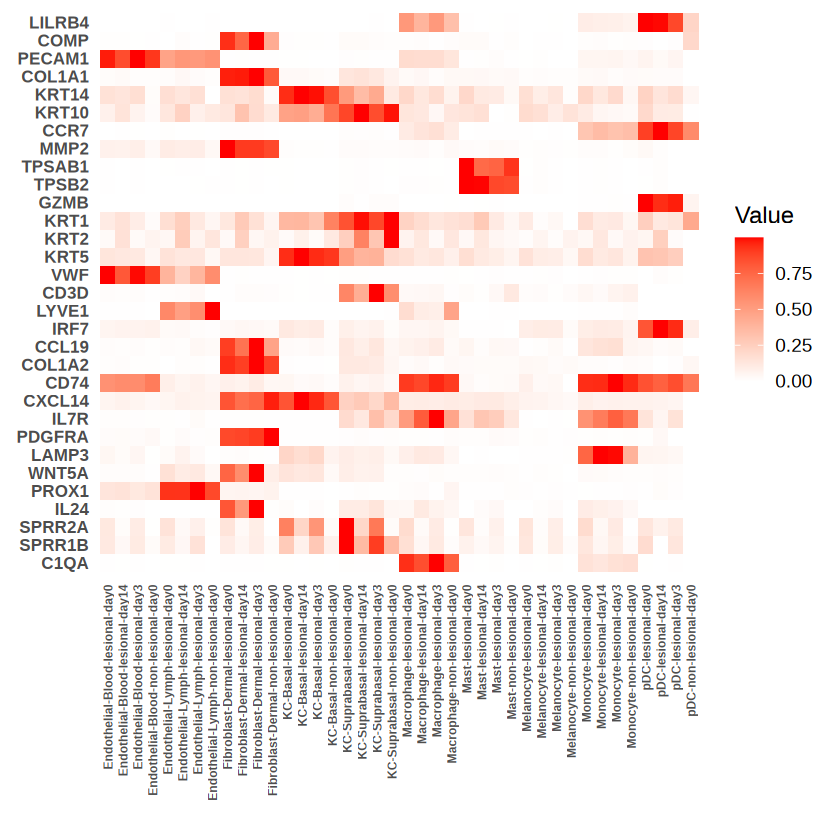

In [6]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(reshape2)

# ---------------------------------------------------
# 1. Paper marker genes
# ---------------------------------------------------
paper_genes <- c(
  # KC
  "KRT14","KRT5","KRT1","KRT10","SPRR1B","SPRR2A","KRT2",
  # FB
  "COL1A1","COL1A2","PDGFRA","CXCL14","MMP2","WNT5A","IL24","COMP","CCL19",
  # EC
  "PECAM1","VWF","PROX1","LYVE1",
  # DC / Myeloid
  "LAMP3","CCR7","LILRB4","C1QA","CD74",
  # pDC
  "GZMB","IRF7",
  # T cells
  "CD3D","IL7R",
  # Mast cells
  "TPSAB1","TPSB2"
)

paper_genes <- intersect(paper_genes, rownames(obj))

# ---------------------------------------------------
# 2. Create a clean Group using actual metadata
# ---------------------------------------------------
obj$Group <- paste(obj$paper_annotation, obj$site, obj$timepoint, sep="_")

# ---------------------------------------------------
# 3. Average expression
# ---------------------------------------------------
avg <- AverageExpression(
  obj,
  features = paper_genes,
  group.by = "Group",
  slot = "data"
)

mat <- avg[[DefaultAssay(obj)]]

# ---------------------------------------------------
# 4. Scale each gene 0–1
# ---------------------------------------------------
scale01 <- function(x) (x - min(x)) / (max(x) - min(x) + 1e-9)
mat_scaled <- t(apply(mat, 1, scale01))

# ---------------------------------------------------
# 5. Long format
# ---------------------------------------------------
long_df <- melt(mat_scaled)
colnames(long_df) <- c("Gene", "Group", "Value")

# ---------------------------------------------------
# 6. Extract metadata *from the meta.data*, not string split
# ---------------------------------------------------
meta <- obj@meta.data %>%
  select(paper_annotation, site, timepoint, Group) %>%
  distinct()

long_df <- left_join(long_df, meta, by="Group")

# ---------------------------------------------------
# 7. Correct ordering using real metadata
# ---------------------------------------------------

# order day
long_df$timepoint <- factor(long_df$timepoint, levels=c("day0","day3","day14"))

# order site
long_df$site <- factor(long_df$site, levels=c("nonlesional","lesional"))

# order final Group: Celltype → Site → Day
ordered_groups <- long_df %>%
  distinct(paper_annotation, site, timepoint, Group) %>%
  arrange(paper_annotation, site, timepoint) %>%
  pull(Group)

long_df$Group <- factor(long_df$Group, levels = ordered_groups)

# ---------------------------------------------------
# 8. Plot heatmap (white -> red)
# ---------------------------------------------------
ggplot(long_df, aes(x = Group, y = Gene, fill = Value)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "red") +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 7, face = "bold"),
    axis.text.y = element_text(size = 10, face = "bold"),
    axis.title = element_blank(),
    panel.grid = element_blank()
  )


Warning message:
“The following 19 features were not found in the integrated assay: BRAP, STX4, FLT3, DDX58, IGLC2, IL18, PRSS53, SPAG1, SGSH, MAP4K5, DKK4, RALB, TNFSF11, CTF1, CRYZ, A2ML1, STAT3, SPHK2, XCL2”


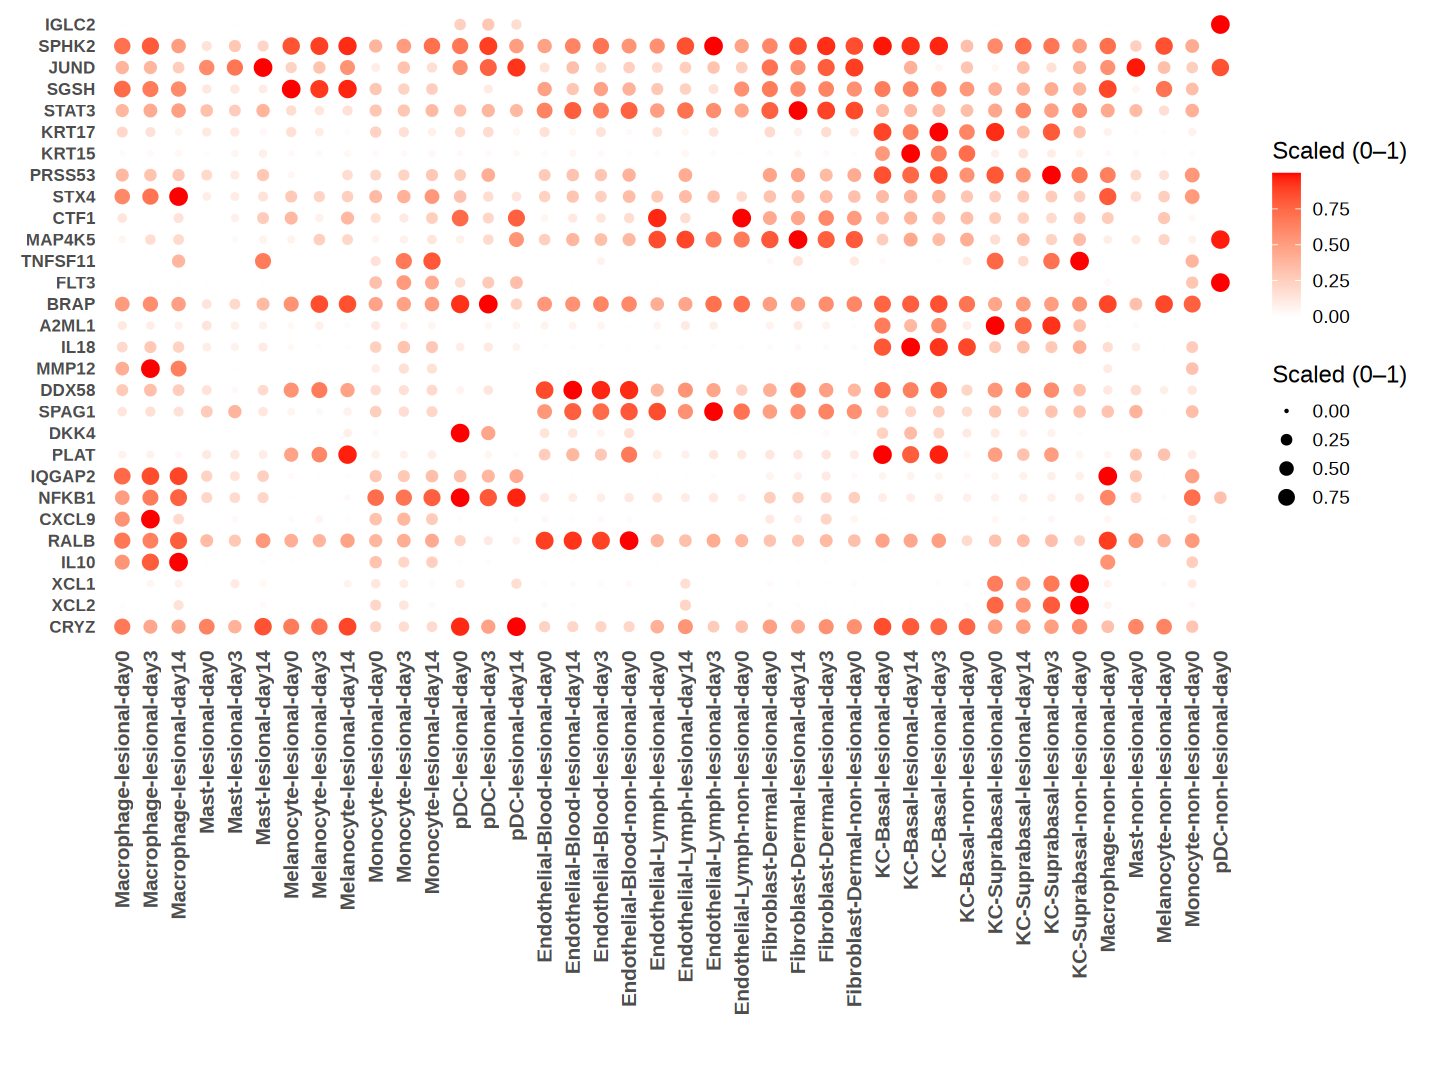

In [7]:
library(Seurat)
library(dplyr)
library(reshape2)
library(ggplot2)

# ---------------------------------------------------
# 1. Genes from your first heatmap
# ---------------------------------------------------
genes_treatment <- c(
  "BRAP","STX4","FLT3","NFKB1","DDX58","CXCL9","IGLC2","IQGAP2","IL18",
  "PRSS53","MMP12","SPAG1","SGSH","XCL1","MAP4K5","DKK4","RALB","PLAT",
  "TNFSF11","IL10","CTF1","CRYZ","A2ML1","STAT3","JUND","SPHK2","XCL2","IL17","IL23", "KRT17","KRT15"
)

genes_treatment <- intersect(genes_treatment, rownames(obj))

# ---------------------------------------------------
# 2. GROUP: Same grouping as your heatmap
# ---------------------------------------------------
obj$Group <- paste(
  obj$paper_annotation,
  obj$site,
  obj$timepoint,
  sep = "-"
)

# ---------------------------------------------------
# 3. Average expression (raw Seurat averaging)
# ---------------------------------------------------
avg <- AverageExpression(
  obj,
  features = genes_treatment,
  group.by = "Group",
  slot = "data"
)[[DefaultAssay(obj)]]

# ---------------------------------------------------
# 4. Scale 0–1 per gene (matching your heatmap scaling)
# ---------------------------------------------------
scale01 <- function(x) (x - min(x)) / (max(x) - min(x) + 1e-9)
avg_scaled <- t(apply(avg, 1, scale01))

# ---------------------------------------------------
# 5. Convert to long format for ggplot DotPlot
# ---------------------------------------------------
df_long <- melt(avg_scaled)
colnames(df_long) <- c("Gene", "Group", "Expression")

# ---------------------------------------------------
# 6. Add metadata directly (NO STRING SPLITTING)
# ---------------------------------------------------
meta <- obj@meta.data |>
  select(
    Group,
    paper_annotation,
    site,
    timepoint
  ) |>
  distinct()

df_long <- left_join(df_long, meta, by = "Group")

# ---------------------------------------------------
# 7. Ordering: Day & Group
# ---------------------------------------------------
df_long$timepoint <- factor(df_long$timepoint,
                            levels = c("day0", "day3", "day14"))

# Order cell types alphabetically (or customize)
df_long$paper_annotation <- factor(
  df_long$paper_annotation,
  levels = sort(unique(df_long$paper_annotation))
)

# Order final Group exactly matching your heatmap
ordered_groups <- df_long |>
  distinct(paper_annotation, site, timepoint, Group) |>
  arrange(paper_annotation, site, timepoint) |>
  pull(Group)

df_long$Group <- factor(df_long$Group, levels = ordered_groups)

# ---------------------------------------------------
# 8. 0–1 Normalized DOTPLOT (manual version)
# ---------------------------------------------------
options(repr.plot.width = 12, repr.plot.height = 9)
ggplot(df_long, aes(x = Group, y = Gene)) +
  geom_point(aes(
    size = Expression,
    color = Expression
  )) +
  scale_color_gradient(low = "white", high = "red") +
  scale_size(range = c(0, 4)) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(
      angle = 90,
      hjust = 1,
      vjust = 0.5,
      size = 12,
      face = "bold"
    ),
    axis.text.y = element_text(size = 10, face = "bold"),
    axis.title = element_blank(),
    panel.grid = element_blank()
  ) +
  guides(
    color = guide_colorbar(title = "Scaled (0–1)"),
    size = guide_legend(title = "Scaled (0–1)")
  )


Warning message:
“The following 19 features were not found in the integrated assay: BRAP, STX4, FLT3, DDX58, IGLC2, IL18, PRSS53, SPAG1, SGSH, MAP4K5, DKK4, RALB, TNFSF11, CTF1, CRYZ, A2ML1, STAT3, SPHK2, XCL2”
Warning message:
“Guides provided to `guides()` must be named.
ℹ The 3rd guide is unnamed.”


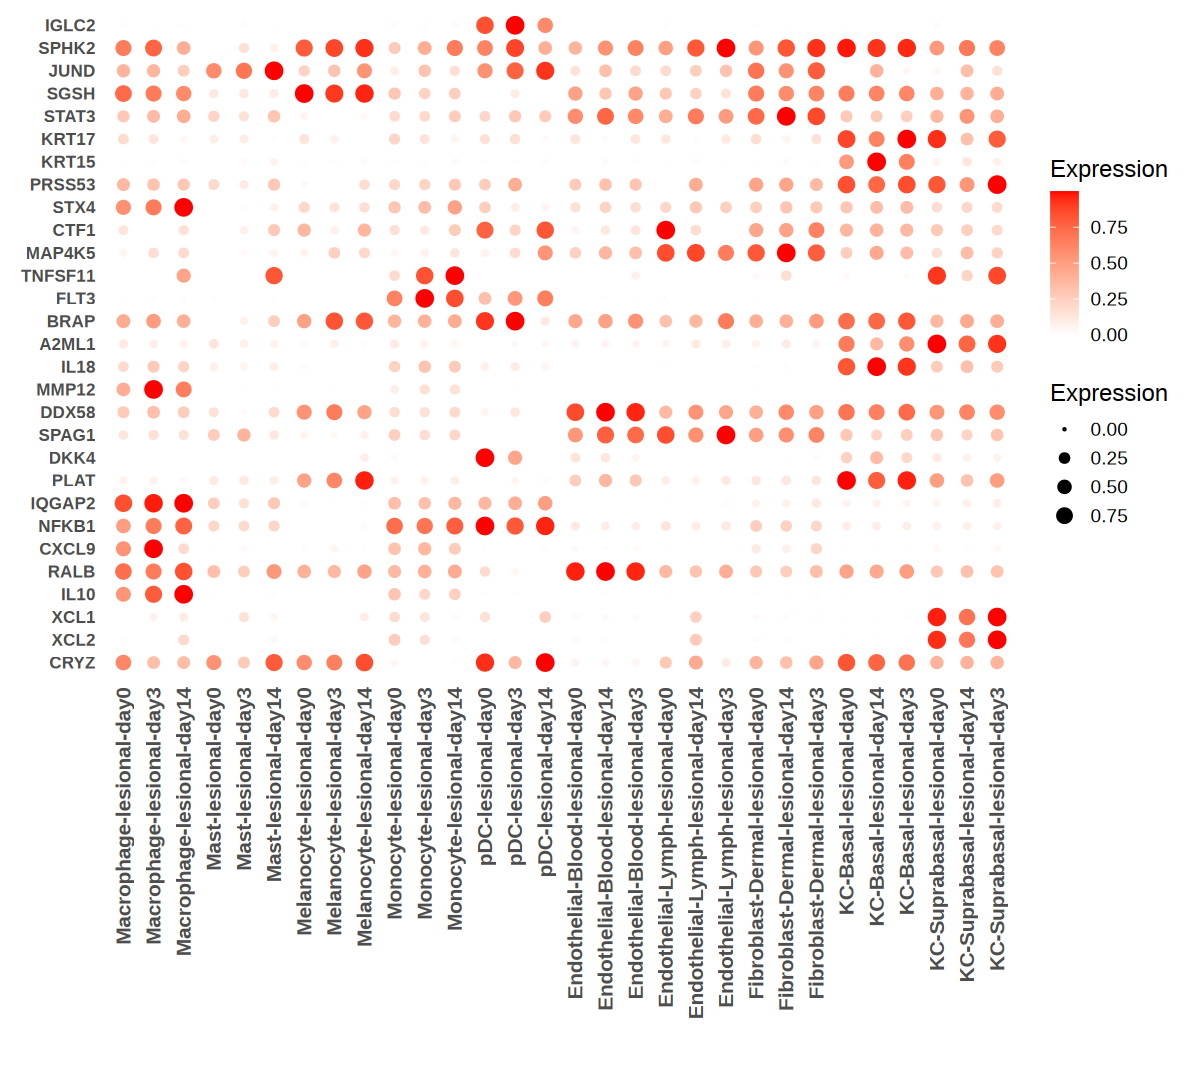

In [8]:
library(Seurat)
library(dplyr)
library(reshape2)
library(ggplot2)

# ---------------------------------------------------
# 1. Genes from your first heatmap
# ---------------------------------------------------
genes_treatment <- c(
  "BRAP","STX4","FLT3","NFKB1","DDX58","CXCL9","IGLC2","IQGAP2","IL18",
  "PRSS53","MMP12","SPAG1","SGSH","XCL1","MAP4K5","DKK4","RALB","PLAT",
  "TNFSF11","IL10","CTF1","CRYZ","A2ML1","STAT3","JUND","SPHK2","XCL2","IL17","IL23", "KRT17","KRT15"
)

genes_treatment <- intersect(genes_treatment, rownames(obj))

# ---------------------------------------------------
# 2. FILTER: Keep only *lesional* samples
# ---------------------------------------------------
obj_L <- subset(obj, subset = site == "lesional")

# ---------------------------------------------------
# 3. GROUP for heatmap-like plotting
# ---------------------------------------------------
obj_L$Group <- paste(
  obj_L$paper_annotation,
  obj_L$site,            # always "lesional"
  obj_L$timepoint,
  sep = "-"
)

# ---------------------------------------------------
# 4. Average expression
# ---------------------------------------------------
avg <- AverageExpression(
  obj_L,
  features = genes_treatment,
  group.by = "Group",
  slot = "data"
)[[DefaultAssay(obj_L)]]

# ---------------------------------------------------
# 5. Scale 0–1 per gene
# ---------------------------------------------------
scale01 <- function(x) (x - min(x)) / (max(x) - min(x) + 1e-9)
avg_scaled <- t(apply(avg, 1, scale01))

# ---------------------------------------------------
# 6. Convert to long format
# ---------------------------------------------------
df_long <- melt(avg_scaled)
colnames(df_long) <- c("Gene", "Group", "Expression")

# ---------------------------------------------------
# 7. Add metadata (from obj_L)
# ---------------------------------------------------
meta <- obj_L@meta.data |>
  select(Group, paper_annotation, site, timepoint) |>
  distinct()

df_long <- left_join(df_long, meta, by = "Group")

# ---------------------------------------------------
# 8. Correct ordering (day0 → day3 → day14)
# ---------------------------------------------------
df_long$timepoint <- factor(df_long$timepoint,
                            levels = c("day0","day3","day14"))

df_long$paper_annotation <- factor(
  df_long$paper_annotation,
  levels = sort(unique(df_long$paper_annotation))
)

ordered_groups <- df_long |>
  distinct(paper_annotation, site, timepoint, Group) |>
  arrange(paper_annotation, timepoint) |>    # only L, so site not needed
  pull(Group)

df_long$Group <- factor(df_long$Group, levels = ordered_groups)

# ---------------------------------------------------
# 9. 0–1 NORMALIZED DOTPLOT (Lesional only)
# ---------------------------------------------------
options(repr.plot.width = 10, repr.plot.height = 9)
ggplot(df_long, aes(x = Group, y = Gene)) +
  geom_point(aes(
    size = Expression,
    color = Expression
  )) +
  scale_color_gradient(low = "white", high = "red") +
  scale_size(range = c(0, 4)) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(
      angle = 90, hjust = 1, vjust = 0.5,
      size = 12, face = "bold"
    ),
    axis.text.y = element_text(size = 10, face = "bold"),
    axis.title = element_blank(),
    panel.grid = element_blank()
  ) +
  guides(
    color = guide_colorbar(title = "Scaled (0–1)"),
    size = guide_legend(title = "Scaled (0–1)"),"XCL2"
  )


In [9]:
str(obj@assays$SCT)

Formal class 'SCTAssay' [package "Seurat"] with 9 slots
  ..@ SCTModel.list:List of 20
  .. ..$ model1   :Formal class 'SCTModel' [package "Seurat"] with 7 slots
  .. .. .. ..@ feature.attributes:'data.frame':	20547 obs. of  12 variables:
  .. .. .. .. ..$ detection_rate       : num [1:20547] 0.00257 0.020468 0.000857 0.045506 0.010377 ...
  .. .. .. .. ..$ gmean                : num [1:20547] 0.001783 0.014524 0.000594 0.03323 0.007258 ...
  .. .. .. .. ..$ variance             : num [1:20547] 0.002564 0.021741 0.000856 0.051931 0.010554 ...
  .. .. .. .. ..$ residual_mean        : num [1:20547] NA NA NA NA NA NA NA NA NA NA ...
  .. .. .. .. ..$ residual_variance    : num [1:20547] 0.064 0.4231 0.0214 0.6803 0.2463 ...
  .. .. .. .. ..$ theta                : num [1:20547] Inf 0.1832 Inf 0.5953 0.0736 ...
  .. .. .. .. ..$ (Intercept)          : num [1:20547] -14.7 -12.5 -15.8 -11.7 -13.2 ...
  .. .. .. .. ..$ log_umi              : num [1:20547] 2.3 2.3 2.3 2.3 2.3 ...
  .. .. .. ..

In [ ]:
library(Seurat)
library(dplyr)
library(ggplot2)

# ===========================================================
# 1. Use RNA assay for DE (Seurat v5 requires JoinLayers)
# ===========================================================
DefaultAssay(obj) <- "RNA"

# FIX: join RNA layers (required for FindMarkers)
obj <- JoinLayers(obj, assay = "RNA")

# ===========================================================
# 2. Gene list
# ===========================================================
genes <- c(
  "BRAP","STX4","FLT3","NFKB1","DDX58","CXCL9","IGLC2","IQGAP2","IL18",
  "PRSS53","MMP12","SPAG1","SGSH","XCL1","MAP4K5","DKK4","RALB","PLAT",
  "TNFSF11","IL10","CTF1","CRYZ","A2ML1","STAT3","JUND","SPHK2","XCL2", "IL17", "IL23", "KRT17","KRT15"
)
genes <- intersect(genes, rownames(obj))

# ===========================================================
# 3. Keep only lesional samples
# ===========================================================
obj_L <- subset(obj, site == "lesional")

# ===========================================================
# 4. Differential Expression per cell type
#    (Day3 vs Day0, Day14 vs Day3)  <-- UPDATED HERE
# ===========================================================
results <- list()

for (ct in unique(obj_L$paper_annotation)) {
  
  message("Processing cell type: ", ct)
  
  sub <- subset(obj_L, paper_annotation == ct)
  
  # IDs MUST come from metadata vector
  Idents(sub) <- sub$timepoint
  
  # -------------------------
  # Day3 – Day0  (UP = treatment-induced early response)
  # -------------------------
  d3_d0 <- FindMarkers(
    sub,
    ident.1 = "day3", ident.2 = "day0",   # <-- UPDATED
    features = genes,
    logfc.threshold = 0,
    min.pct = 0
  )
  d3_d0$gene <- rownames(d3_d0)
  d3_d0$comparison <- "Day3_vs_Day0"
  d3_d0$celltype <- ct
  
  # -------------------------
  # Day14 – Day3  (UP = treatment-induced late response)
  # -------------------------
  d14_d3 <- FindMarkers(
    sub,
    ident.1 = "day14", ident.2 = "day3",  # <-- UPDATED
    features = genes,
    logfc.threshold = 0,
    min.pct = 0
  )
  d14_d3$gene <- rownames(d14_d3)
  d14_d3$comparison <- "Day14_vs_Day3"
  d14_d3$celltype <- ct
  
  results[[ct]] <- rbind(d3_d0, d14_d3)
}

# ===========================================================
# 5. Combine all DE results
# ===========================================================
de_all <- do.call(rbind, results)

# Add metrics for plotting
de_all$logFC <- de_all$avg_log2FC
de_all$neglog10_p <- -log10(de_all$p_val_adj + 1e-300)

# Add significance stars
de_all$signif <- ifelse(
  de_all$p_val_adj < 0.01, "**",
  ifelse(de_all$p_val_adj < 0.05, "*", "")
)

# ===========================================================
# 6. Count cells per celltype and day
# ===========================================================
cell_counts <- obj_L@meta.data %>%
  group_by(paper_annotation, timepoint) %>%
  summarise(n_cells = n()) %>%
  rename(celltype = paper_annotation, day = timepoint)

raw_cell_counts <- cell_counts

# ===========================================================
# 7. Save DE + cell count tables
# ===========================================================
write.csv(de_all, "DE_results_treatment_direction.csv", row.names = FALSE)
write.csv(raw_cell_counts, "Cell_counts_per_day.csv", row.names = FALSE)

# ===========================================================
# 8. DotPlot (facet by cell type, comparisons side-by-side)
# ===========================================================
de_all$comparison <- factor(
  de_all$comparison,
  levels = c("Day3_vs_Day0", "Day14_vs_Day3")  # <-- UPDATED ORDER
)

de_all$gene <- factor(de_all$gene, levels = genes)

de_all$celltype <- factor(
  de_all$celltype,
  levels = sort(unique(obj_L$paper_annotation))
)

options(repr.plot.width = 6, repr.plot.height = 10)
p <- ggplot(de_all, aes(
  x = comparison,
  y = gene
)) +
  geom_point(aes(
    color = logFC,
    size = neglog10_p
  ), alpha = 0.9) +
  geom_text(
    aes(label = signif),
    color = "black",
    fontface = "bold",
    size = 3,
    vjust = -0.8
  ) +
  scale_color_gradient2(
    low = "blue", mid = "white", high = "red",
    midpoint = 0
  ) +
  scale_size(range = c(1.5, 7)) +
  facet_wrap(~celltype, nrow = 1, strip.position = "bottom") +
  theme_minimal(base_size = 14) +
  theme(
    strip.text = element_text(size = 12, face = "bold", angle = 90),
    axis.text.x = element_text(size = 10, angle = 90, hjust = 1, face = "bold"),
    axis.text.y = element_text(size = 10, face = "bold"),
    panel.grid = element_blank()
  ) +
  labs(
    x = "",
    y = "Genes",
    color = "log2FC",
    size = "-log10(adj p)"
  )

print(p)

# ===========================================================
# 9. Save the plot (optional)
# ===========================================================
ggsave("DE_dotplot_facet.png", p, width = 18, height = 5, dpi = 300)



Processing cell type: KC_Suprabasal

Processing cell type: Fibroblast_Dermal

Processing cell type: KC_Basal

Processing cell type: Endothelial_Blood

Processing cell type: Endothelial_Lymph

Processing cell type: Melanocyte

Processing cell type: Monocyte

Processing cell type: Mast

Processing cell type: Macrophage

Processing cell type: pDC

`summarise()` has grouped output by 'paper_annotation'. You can override using
the `.groups` argument.


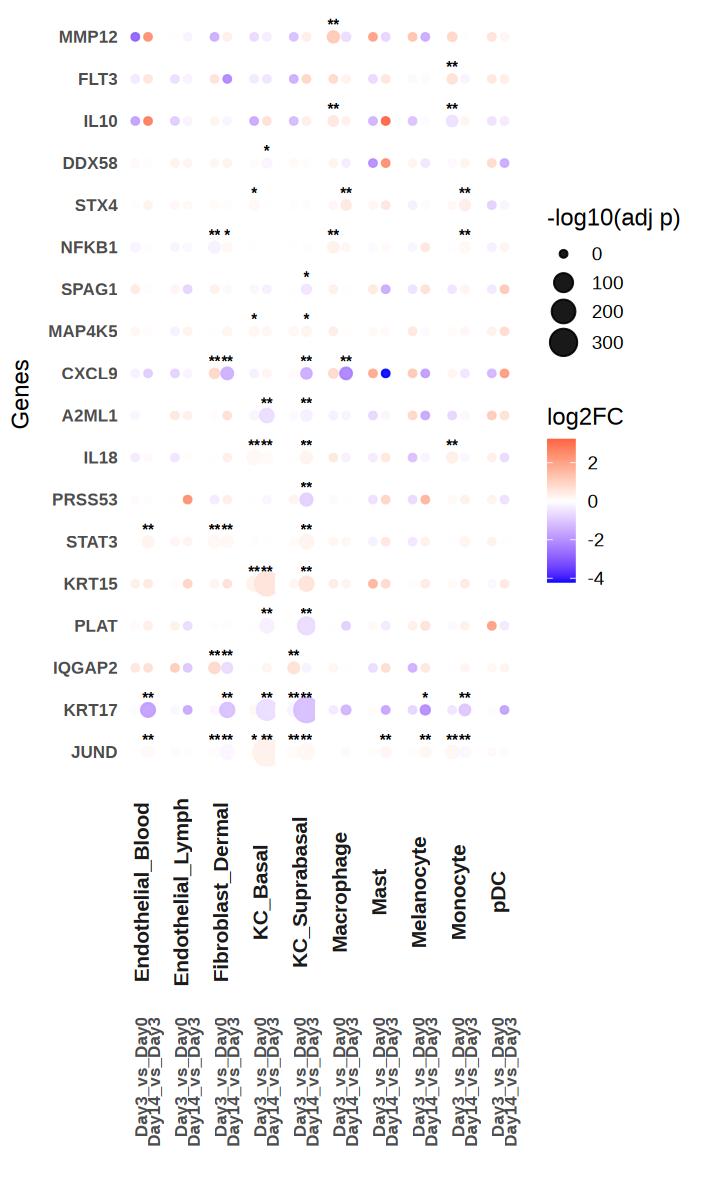

In [ ]:
library(Seurat)
library(dplyr)
library(ggplot2)

# ===========================================================
# 1. Use RNA assay for DE (Seurat v5 requires JoinLayers)
# ===========================================================
DefaultAssay(obj) <- "RNA"

# FIX: join RNA layers (required for FindMarkers)
obj <- JoinLayers(obj, assay = "RNA")

# ===========================================================
# 2. Gene list
# ===========================================================
genes <- c(
    "BRAP", "STX4", "FLT3", "NFKB1", "DDX58", "CXCL9", "IGLC2", "IQGAP2", "IL18",
    "PRSS53", "MMP12", "SPAG1", "SGSH", "XCL1", "MAP4K5", "DKK4", "RALB", "PLAT",
    "TNFSF11", "IL10", "CTF1", "CRYZ", "A2ML1", "STAT3", "JUND", "SPHK2", "XCL2",
    "IL17", "IL23", "KRT17", "KRT15"
)
genes <- intersect(genes, rownames(obj))

# ===========================================================
# 3. Keep only lesional samples
# ===========================================================
obj_L <- subset(obj, site == "lesional")

# ===========================================================
# 4. Differential Expression per cell type
# ===========================================================
results <- list()

for (ct in unique(obj_L$paper_annotation)) {
    message("Processing cell type: ", ct)

    sub <- subset(obj_L, paper_annotation == ct)
    Idents(sub) <- sub$timepoint

    # -------------------------
    # Day3 – Day0
    # -------------------------
    d3_d0 <- FindMarkers(
        sub,
        ident.1 = "day3", ident.2 = "day0",
        features = genes,
        logfc.threshold = 0,
        min.pct = 0
    )
    d3_d0$gene <- rownames(d3_d0)
    d3_d0$comparison <- "Day3_vs_Day0"
    d3_d0$celltype <- ct

    # -------------------------
    # Day14 – Day3
    # -------------------------
    d14_d3 <- FindMarkers(
        sub,
        ident.1 = "day14", ident.2 = "day3",
        features = genes,
        logfc.threshold = 0,
        min.pct = 0
    )
    d14_d3$gene <- rownames(d14_d3)
    d14_d3$comparison <- "Day14_vs_Day3"
    d14_d3$celltype <- ct

    results[[ct]] <- rbind(d3_d0, d14_d3)
}

# ===========================================================
# 5. Combine all DE results
# ===========================================================
de_all <- do.call(rbind, results)

# -----------------------------------------------------------
# 5b. KEEP ONLY GENES SIGNIFICANT IN AT LEAST ONE CELL TYPE
# -----------------------------------------------------------
sig_genes <- de_all %>%
    filter(p_val_adj < 0.05) %>%
    pull(gene) %>%
    unique()

de_all <- de_all %>% filter(gene %in% sig_genes)

# Proper factor order for plotting
de_all$gene <- factor(de_all$gene, levels = sig_genes)

# Add metrics for plotting
de_all$logFC <- de_all$avg_log2FC
de_all$neglog10_p <- -log10(de_all$p_val_adj + 1e-300)

# Add significance stars
de_all$signif <- ifelse(
    de_all$p_val_adj < 0.01, "**",
    ifelse(de_all$p_val_adj < 0.05, "*", "")
)

# ===========================================================
# 6. Count cells per celltype and day
# ===========================================================
cell_counts <- obj_L@meta.data %>%
    group_by(paper_annotation, timepoint) %>%
    summarise(n_cells = n()) %>%
    rename(celltype = paper_annotation, day = timepoint)

raw_cell_counts <- cell_counts

# ===========================================================
# 7. Save DE + cell count tables
# ===========================================================
write.csv(de_all, "DE_results_treatment_direction.csv", row.names = FALSE)
write.csv(raw_cell_counts, "Cell_counts_per_day.csv", row.names = FALSE)

# ===========================================================
# 8. DotPlot (facet by cell type)
# ===========================================================
de_all$comparison <- factor(
    de_all$comparison,
    levels = c("Day3_vs_Day0", "Day14_vs_Day3")
)

de_all$celltype <- factor(
    de_all$celltype,
    levels = sort(unique(obj_L$paper_annotation))
)

options(repr.plot.width = 6, repr.plot.height = 10)
p <- ggplot(de_all, aes(
    x = comparison,
    y = gene
)) +
    geom_point(aes(
        color = logFC,
        size = neglog10_p
    ), alpha = 0.9) +
    geom_text(
        aes(label = signif),
        color = "black",
        fontface = "bold",
        size = 3,
        vjust = -0.8
    ) +
    scale_color_gradient2(
        low = "blue", mid = "white", high = "red",
        midpoint = 0
    ) +
    scale_size(range = c(1.5, 7)) +
    facet_wrap(~celltype, nrow = 1, strip.position = "bottom") +
    theme_minimal(base_size = 14) +
    theme(
        strip.text = element_text(size = 12, face = "bold", angle = 90),
        axis.text.x = element_text(size = 10, angle = 90, hjust = 1, face = "bold"),
        axis.text.y = element_text(size = 10, face = "bold"),
        panel.grid = element_blank()
    ) +
    labs(
        x = "",
        y = "Genes",
        color = "log2FC",
        size = "-log10(adj p)"
    )

print(p)

# ===========================================================
# 9. Save the plot
# ===========================================================
ggsave("DE_dotplot_facet.png", p, width = 18, height = 5, dpi = 300)


In [ ]:
setdiff(
    c(
        "BRAP", "STX4", "FLT3", "NFKB1", "DDX58", "CXCL9", "IGLC2", "IQGAP2", "IL18",
        "PRSS53", "MMP12", "SPAG1", "SGSH", "XCL1", "MAP4K5", "DKK4", "RALB", "PLAT",
        "TNFSF11", "IL10", "CTF1", "CRYZ", "A2ML1", "STAT3", "JUND", "SPHK2", "XCL2", "IL17", "IL23", "KRT17","KRT15"
    ),
    rownames(obj)
)


[1] "IL17" "IL23"

In [ ]:
library(Seurat)
library(dplyr)
library(ggplot2)

# ===========================================================
# 1. Use RNA assay for DE (Seurat v5 requires JoinLayers)
# ===========================================================
DefaultAssay(obj) <- "RNA"
obj <- JoinLayers(obj, assay = "RNA") # required for FindMarkers

# ===========================================================
# 2. Gene list
# ===========================================================
genes <- c(
    "BRAP", "STX4", "FLT3", "NFKB1", "DDX58", "CXCL9", "IGLC2", "IQGAP2", "IL18",
    "PRSS53", "MMP12", "SPAG1", "SGSH", "XCL1", "MAP4K5", "DKK4", "RALB", "PLAT",
    "TNFSF11", "IL10", "CTF1", "CRYZ", "A2ML1", "STAT3", "JUND", "SPHK2", "XCL2", "IL17", "IL23", "KRT17","KRT15"
)
genes <- intersect(genes, rownames(obj))

# ===========================================================
# 3. Keep only lesional samples
# ===========================================================
obj_L <- subset(obj, site == "lesional")

# ===========================================================
# 4. Differential Expression per cell type
#    (Day14 vs Day0 — only comparison)
# ===========================================================
results <- list()

for (ct in unique(obj_L$paper_annotation)) {
    message("Processing cell type: ", ct)

    sub <- subset(obj_L, paper_annotation == ct)
    Idents(sub) <- sub$timepoint # identities come from metadata

    # Day14 – Day0 (positive = upregulated with treatment)
    d14_d0 <- FindMarkers(
        sub,
        ident.1 = "day14", ident.2 = "day0",
        features = genes,
        logfc.threshold = 0,
        min.pct = 0
    )

    d14_d0$gene <- rownames(d14_d0)
    d14_d0$comparison <- "Day14_vs_Day0"
    d14_d0$celltype <- ct

    results[[ct]] <- d14_d0
}

# ===========================================================
# 5. Combine all DE results
# ===========================================================
de_all <- do.call(rbind, results)

# Add useful columns
de_all$logFC <- de_all$avg_log2FC
de_all$neglog10_p <- -log10(de_all$p_val_adj + 1e-300)
de_all$signif <- ifelse(
    de_all$p_val_adj < 0.01, "**",
    ifelse(de_all$p_val_adj < 0.05, "*", "")
)

# ===========================================================
# 6. Save results to CSV
# ===========================================================
write.csv(de_all, "DE_results_Day14_vs_Day0.csv", row.names = FALSE)

# ===========================================================
# 7. DotPlot for Day14 vs Day0
# ===========================================================
de_all$gene <- factor(de_all$gene, levels = genes)
de_all$celltype <- factor(de_all$celltype, levels = sort(unique(obj_L$paper_annotation)))


Processing cell type: KC_Suprabasal

Processing cell type: Fibroblast_Dermal

Processing cell type: KC_Basal

Processing cell type: Endothelial_Blood

Processing cell type: Endothelial_Lymph

Processing cell type: Melanocyte

Processing cell type: Monocyte

Processing cell type: Mast

Processing cell type: Macrophage

Processing cell type: pDC



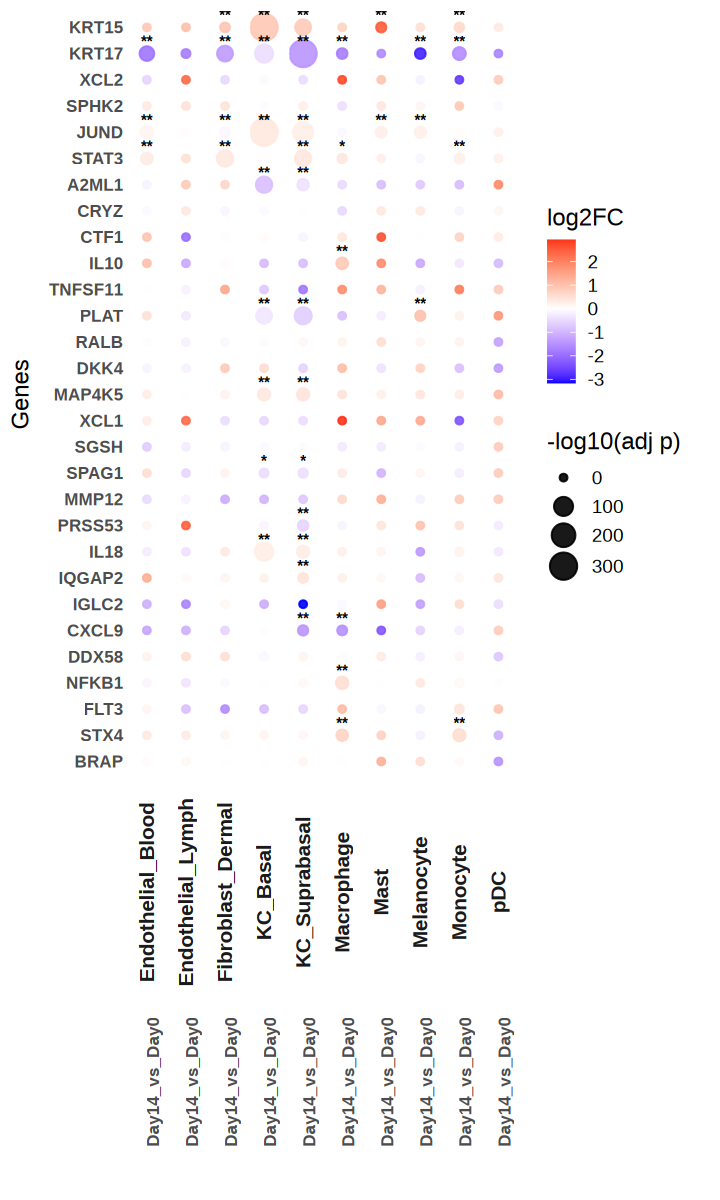

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 10)
p <- ggplot(de_all, aes(
    x = comparison,
    y = gene
)) +
    geom_point(aes(
        color = logFC,
        size = neglog10_p
    ), alpha = 0.9) +
    geom_text(
        aes(label = signif),
        color = "black",
        fontface = "bold",
        size = 3,
        vjust = -0.8
    ) +
    scale_color_gradient2(
        low = "blue", mid = "white", high = "red",
        midpoint = 0
    ) +
    scale_size(range = c(1.5, 7)) +
    facet_wrap(~celltype, nrow = 1, strip.position = "bottom") +
    theme_minimal(base_size = 14) +
    theme(
        strip.text = element_text(size = 12, face = "bold", angle = 90),
        axis.text.x = element_text(size = 10, angle = 90, hjust = 1, face = "bold"),
        axis.text.y = element_text(size = 10, face = "bold"),
        panel.grid = element_blank()
    ) +
    labs(
        x = "",
        y = "Genes",
        color = "log2FC",
        size = "-log10(adj p)"
    )

print(p)

# ===========================================================
# 9. Save the plot (optional)
# ===========================================================
ggsave("DE_dotplot_day14_vs_Day0_facet.png", p, width = 18, height = 5, dpi = 300)
